### Common functions

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def model_test(model, X_test, y_test, labels):
    """
    Evaluate the model on the test set and print the classification report and confusion matrix.

    Args:
        model: The trained model to evaluate.
        X_test: The test features.
        y_test: The true labels for the test set.
        labels: The list of class labels.
    """

    print("\n[INFO] Best parameters found:")
    for param, value in model.best_params_.items():
        print(f"   {param}: {value}")
    print("\n[INFO] Best score achieved:")
    print(f"   {model.best_score_:.4f}")

    y_pred = model.predict(X_test)
    print("\n[INFO] Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels, digits=4))

    print("\n[INFO] Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 1. Conversation

Each input to the model consists of an entire conversation, obtained by concatenating all turns into a single string. Speaker names, turn numbers, and extra spaces are removed to provide a clean, uninterrupted representation of the dialogue.

In [2]:
import json
from util import clean_turn

def preprocess_inference_data(json_inference_path: str, add_speaker: bool = False, remove_stopwords=False, lemmatize=False):
    """
    Preprocess the inference data from the JSON file.

    Args:
        json_inference_path (str): Path to the JSON file containing inference data.
        remove_stopwords (bool): Whether to remove stopwords.
        lemmatize (bool): Whether to lemmatize the text.

    Returns:
        tuple: A tuple containing the preprocessed texts and their corresponding labels.
    """

    inference_texts = []
    inference_labels = []
    
    with open(json_inference_path, "r") as file:
        conversations = json.load(file)
        for conversation in conversations:
            cleaned_turns = [clean_turn(turn['text'], remove_stopwords=remove_stopwords, lemmatize=lemmatize) for turn in conversation['conversation']]
            conversation_text = ""
            if not add_speaker:
                conversation_text = ' [TURN_SEP] '.join(cleaned_turns)
            else:
                for idx, turn in enumerate(cleaned_turns):
                    conversation_text += f"[SPEAKER1] {turn}" if idx % 2 == 0 else f"[SPEAKER2] {turn}"
                    if idx < len(cleaned_turns) - 1:
                        conversation_text += " [TURN_SEP] "
            inference_texts.append(conversation_text)
            inference_labels.append(conversation['person_couple'])

    return inference_texts, inference_labels

### 1.1 Logistic Regression + TF-IDF

Fitting 5 folds for each of 180 candidates, totalling 900 fits

[INFO] Best parameters found:
   classifier__C: 1
   classifier__penalty: l2
   classifier__solver: saga
   vectorizer__min_df: 5
   vectorizer__ngram_range: (1, 2)

[INFO] Best score achieved:
   0.6823

[INFO] Classification Report:
                                          precision    recall  f1-score   support

                   Controllore e Isolata     0.5161    0.7619    0.6154        21
             Dominante e Schiavo emotivo     0.7059    0.8571    0.7742        14
           Geloso-Ossessivo e Sottomessa     1.0000    0.5833    0.7368        24
       Manipolatore e Dipendente emotiva     0.7692    0.5556    0.6452        18
                    Narcisista e Succube     0.6667    0.7059    0.6857        17
Perfezionista Critico e Insicura Cronica     0.5789    0.5500    0.5641        20
              Persona violenta e Succube     0.8824    0.7500    0.8108        20
                Psicopatico e Adulatrice    

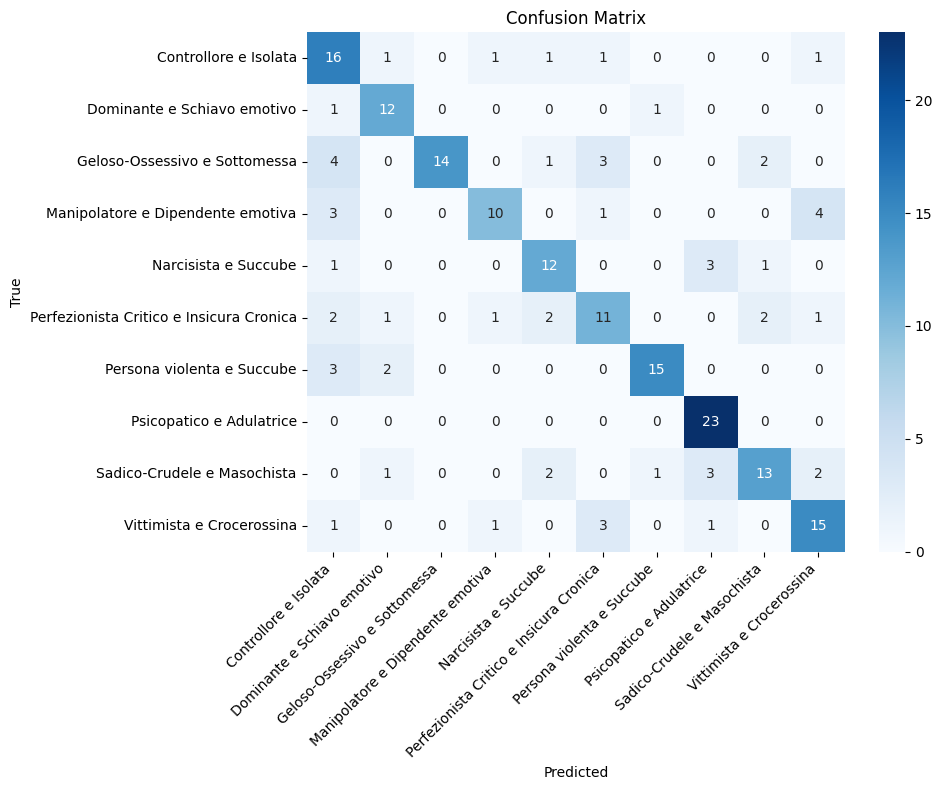


[INFO] Inference Predictions:
   Text: ho fatto licenziare quel collega incompetente bastava inoltrare una mail anonima con qualche voce infondata era l unico modo per liberarcene [TURN_SEP] amore sei un genio nessun altro avrebbe avuto il coraggio o l intelligenza di fare una cosa del genere ãˆ per questo che sei destinato a grandi cose [TURN_SEP] la maggior parte delle persone ã troppo debole e sentimentale non capiscono come funziona il mondo sono solo ostacoli [TURN_SEP] esatto tu vedi le cose per come sono senza filtri ãˆ un dono sono cosã fortunata ad avere un uomo che sa cosa vuole e come ottenerlo a qualsiasi costo
   True Label: Psicopatico e Adulatrice
   Predicted Label: Narcisista e Succube

   Text: marco stasera volevo parlarti mi sento un po trascurata ultimamente come se fossi sempre l ultima delle tue prioritã [TURN_SEP] vedi ãˆ sempre cosã con te non appena ho un momento di stress al lavoro tu me lo fai pesare non pensi mai che forse ho bisogno di sostegno invece che

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
import json
import os

from util import get_root_path, clean_turn


# ---- Define constants ----
JSON_DATASET = os.path.join(get_root_path(), "dataset", "toxic_conversation.json")
JSON_INFERENCE_PATH = os.path.join(get_root_path(), "dataset", "inference_test_multiclass.json")
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
conversations = []
labels = []
with open(JSON_DATASET, 'r', encoding='utf-8') as f:
    data = json.load(f)
    for conv in data:
        text = ""
        for idx, turn in enumerate(conv['conversation']):
            text += clean_turn(turn['text'], remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
            if idx < len(conv['conversation']) - 1:
                text += " "
        conversations.append(text)
        labels.append(conv['person_couple'])

X_train, X_test, y_train, y_test = train_test_split(conversations, labels, test_size=0.2, random_state=42)
labels = sorted(set(labels))


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga', 'liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(JSON_INFERENCE_PATH, add_speaker=False, remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

### 1.2 Italian Bert Fine Tuning

[INFO] Initializing ConversationDataLoader with:
	dataset path: c:\Home\Uniba\CIPV-Classification-NLP\src\..\dataset\toxic_conversation.csv,
	test size: 0.2,
	val size: 0.1,
	max length: 512,
	random state: 42,
	remove stopwords: False,
	lemmatize: False

[INFO] ConversationDataLoader initialized with 700 training samples.
[INFO] Sizes of datasets:
	train dataset: 700,
	val dataset: 100,
	test dataset: 200


[INFO] Initializing CustomModel with:
	model name: dbmdz/bert-base-italian-cased,
	output dir: c:\Home\Uniba\CIPV-Classification-NLP\src\..\models\bert-base-italian-cased_finetuned_conversation,
	batch size: 16,
	learning rate: 2e-05,
	num epochs: 50,
	weight decay: 0.01,
	max grad norm: 1.0,
	seed: 42
	early stopping patience: 4,
	early stopping threshold: 0.005



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


[INFO] CustomModel initialized with:
	700 train examples,
	100 validation examples, and
	200 test examples.


[INFO] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,2.320900,2.313029,0.072917,0.031976,0.070000,0.033919
2,2.297900,2.282898,0.156250,0.110758,0.152222,0.105854
3,2.281400,2.260854,0.208333,0.179228,0.211111,0.164773
4,2.251500,2.237335,0.197917,0.116301,0.192222,0.141613
5,2.195000,2.202087,0.229167,0.313529,0.226667,0.195497
6,2.087900,2.081726,0.250000,0.198265,0.245556,0.188755
7,1.867800,1.800110,0.468750,0.449806,0.471111,0.438378
8,1.572600,1.599140,0.593750,0.659949,0.592222,0.573653
9,1.251500,1.377537,0.635417,0.677023,0.631111,0.618932
10,0.985000,1.215807,0.656250,0.708661,0.654444,0.640579


[INFO] Training complete.


[INFO] Evaluation metrics:


   eval_loss: 1.1545, 
   eval_accuracy: 0.7708, 
   eval_precision: 0.8004, 
   eval_recall: 0.7700, 
   eval_macro_f1: 0.7652



[INFO] Evaluation results on test dataset:
                                          precision    recall  f1-score   support

                   Controllore e Isolata       0.69      0.55      0.61        20
             Dominante e Schiavo emotivo       0.83      0.79      0.81        19
           Geloso-Ossessivo e Sottomessa       0.64      0.53      0.58        17
       Manipolatore e Dipendente emotiva       0.58      0.55      0.56        20
                    Narcisista e Succube       0.68      0.68      0.68        19
Perfezionista Critico e Insicura Cronica       0.52      0.55      0.54        20
              Persona violenta e Succube       0.62      0.75      0.68        20
                Psicopatico e Adulatrice       0.75      0.83      0.79        18
             Sadico-Crudele e Masochista       0.52      0.65      0.58        20
     

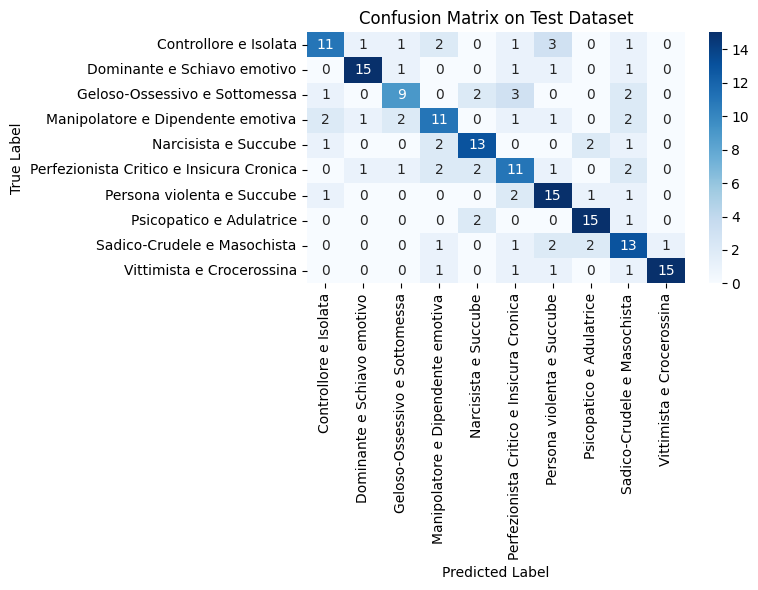

[INFO] Plotting training and evaluation loss...


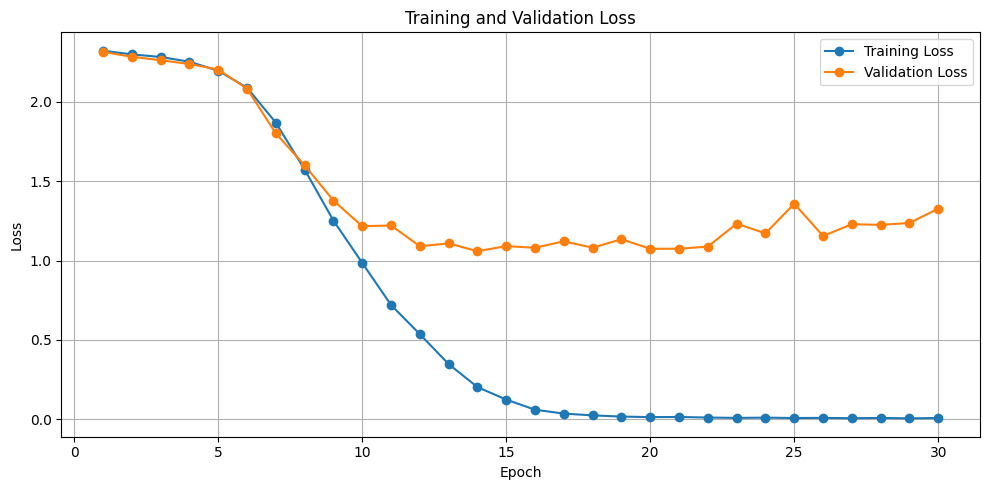

[INFO] Saving model and tokenizer
[INFO] Model and tokenizer saved to c:\Home\Uniba\CIPV-Classification-NLP\src\..\models\bert-base-italian-cased_finetuned_conversation.




In [20]:
# ---- Import necessary libraries ----
import warnings
warnings.simplefilter("ignore")

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os
import torch

from fine_tuning.datasets import ConversationDataLoader
from fine_tuning.models import CustomModel
from util import get_root_path


# ---- Define constants ----
MODEL_NAME = 'dbmdz/bert-base-italian-cased'
JSON_DATASET_PATH = os.path.join(get_root_path(), "dataset", "toxic_conversation.csv")
OUTPUT_MODEL_PATH = os.path.join(get_root_path(), 'models', f'{MODEL_NAME.split("/")[-1]}_finetuned_conversation')
INFERENCE_TEST_JSON = os.path.join(get_root_path(), "dataset", "inference_test_multiclass.json")
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Tokenizer and Dataset Setup ----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

data_loader = ConversationDataLoader(
    csv_dataset_path=JSON_DATASET_PATH,
    tokenizer=tokenizer,
    text_column='conversation',
    label_column='person_couple',
    remove_stopwords=REMOVE_STOPWORDS,
    lemmatize=LEMMATIZE,
)

train_dataset, val_dataset, test_dataset = data_loader.get_datasets()  # Get the train, validation, and test datasets


# ---- 2. Model Initialization ----
model = CustomModel(
    model_name=MODEL_NAME,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    labels=data_loader.get_label_names(),
    output_dir=OUTPUT_MODEL_PATH,
    batch_size=16,
    learning_rate=2e-5,
    num_epochs=50,
)


# ---- 3. Model Training ----
model.train()  # Train the model


# ---- 4. Model Evaluation ----
model.evaluate()  # Evaluate the model on the test dataset


# ---- 5. Save the model ----
model.save_model()  # Save the trained model and tokenizer

In [21]:
# ---- 6. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(INFERENCE_TEST_JSON, add_speaker=True, remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)

accuracy = 0
print("\n[INFO] Inference Predictions:")

tokenizer = AutoTokenizer.from_pretrained(OUTPUT_MODEL_PATH)  # Load the tokenizer
model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_MODEL_PATH)  # Load the model
model.eval()

inputs = tokenizer(inference_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)  # Tokenize the input text
with torch.no_grad():  # Disable gradient calculation
    outputs = model(**inputs)
    outputs = outputs.logits.argmax(dim=1)  # Get the predicted class indices
    inference_predictions = [model.config.id2label[idx.item()] for idx in outputs]
    for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
        print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
        if true_label == pred_label:
            accuracy += 1
    print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")


[INFO] Inference Predictions:
   Text: [SPEAKER1] ho fatto licenziare quel collega incompetente bastava inoltrare una mail anonima con qualche voce infondata era l unico modo per liberarcene [TURN_SEP] [SPEAKER2] amore sei un genio nessun altro avrebbe avuto il coraggio o l intelligenza di fare una cosa del genere ãˆ per questo che sei destinato a grandi cose [TURN_SEP] [SPEAKER1] la maggior parte delle persone ã troppo debole e sentimentale non capiscono come funziona il mondo sono solo ostacoli [TURN_SEP] [SPEAKER2] esatto tu vedi le cose per come sono senza filtri ãˆ un dono sono cosã fortunata ad avere un uomo che sa cosa vuole e come ottenerlo a qualsiasi costo
   True Label: Psicopatico e Adulatrice
   Predicted Label: Narcisista e Succube

   Text: [SPEAKER1] marco stasera volevo parlarti mi sento un po trascurata ultimamente come se fossi sempre l ultima delle tue prioritã [TURN_SEP] [SPEAKER2] vedi ãˆ sempre cosã con te non appena ho un momento di stress al lavoro tu me lo fa

---------------------

# 2. Turns

Each input consists of the individual turns from a conversation, presented in their original order. Turns are separated by a custom separator, and both speaker names and turn numbers are removed to reduce textual noise while retaining the dialogic structure. The label associated with each turn corresponds to the label of the full conversation it belongs to.

In [7]:
import json
from util import clean_turn

def preprocess_inference_data(json_inference_path: str, remove_stopwords=False, lemmatize=False):
    """
    Preprocess the inference data from the JSON file.

    Args:
        json_inference_path (str): Path to the JSON file containing inference data.
        remove_stopwords (bool): Whether to remove stopwords.
        lemmatize (bool): Whether to lemmatize the text.

    Returns:
        tuple: A tuple containing the preprocessed texts and their corresponding labels.
    """

    inference_texts = []
    inference_labels = []
    
    with open(json_inference_path, "r") as file:
        conversations = json.load(file)
        for conversation in conversations:
            cleaned_turns = [clean_turn(turn['text'], remove_stopwords=remove_stopwords, lemmatize=lemmatize) for turn in conversation['conversation']]
            inference_texts.append(cleaned_turns)
            inference_labels.append(conversation['person_couple'])

    return inference_texts, inference_labels

### 2.1 Logistic Regression + TF-IDF

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\cirul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



[INFO] Best parameters found:
   classifier__C: 10
   classifier__penalty: l2
   classifier__solver: liblinear
   vectorizer__min_df: 1
   vectorizer__ngram_range: (1, 2)

[INFO] Best score achieved:
   0.5302

[INFO] Classification Report:
                                          precision    recall  f1-score   support

                   Controllore e Isolata     0.5123    0.6649    0.5787       188
             Dominante e Schiavo emotivo     0.5657    0.6961    0.6242       204
           Geloso-Ossessivo e Sottomessa     0.6639    0.5232    0.5852       151
       Manipolatore e Dipendente emotiva     0.5902    0.4364    0.5017       165
                    Narcisista e Succube     0.5593    0.4552    0.5019       145
Perfezionista Critico e Insicura Cronica     0.5852    0.5267    0.5544       150
              Persona violenta e Succube     0.5366    0.6256    0.5777       211
                Psicopatico e Adulatrice     0.5954    0.6168    0.6059       167
             Sadico

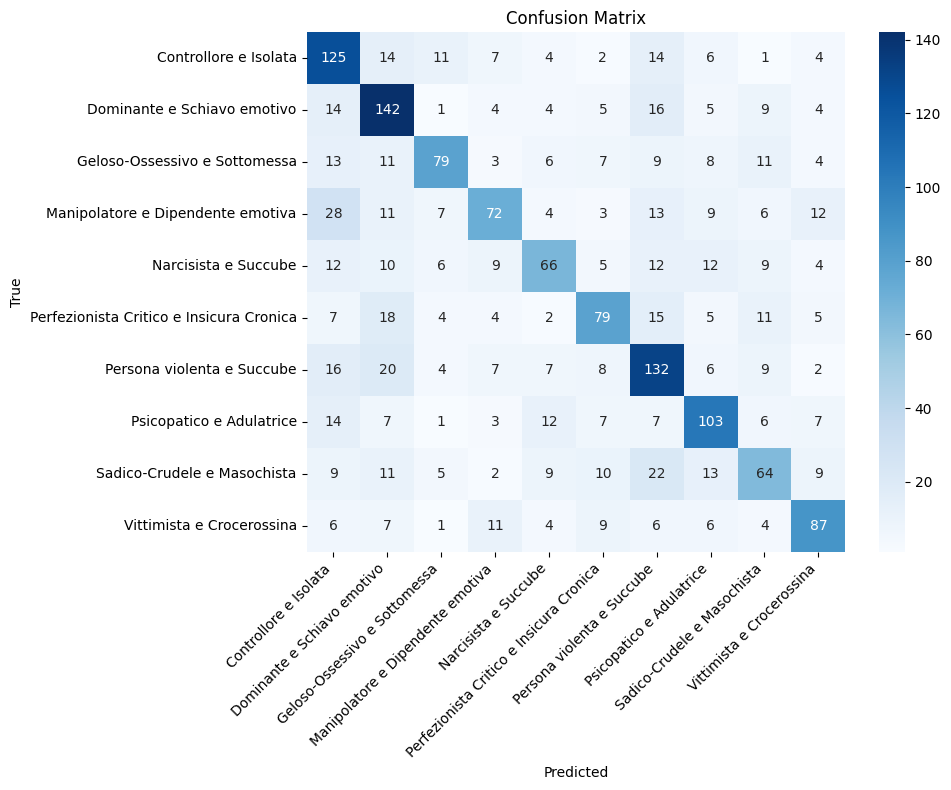


[INFO] Inference Predictions:
   Text: ["Ho fatto licenziare quel collega incompetente. Bastava inoltrare una mail anonima con qualche voce infondata. Era l'unico modo per liberarcene. [TURN_SEP] Amore, sei un genio. Nessun altro avrebbe avuto il coraggio o l'intelligenza di fare una cosa del genere. Ãˆ per questo che sei destinato a grandi cose. [TURN_SEP] La maggior parte delle persone Ã¨ troppo debole e sentimentale. Non capiscono come funziona il mondo. Sono solo ostacoli.", "Amore, sei un genio. Nessun altro avrebbe avuto il coraggio o l'intelligenza di fare una cosa del genere. Ãˆ per questo che sei destinato a grandi cose. [TURN_SEP] La maggior parte delle persone Ã¨ troppo debole e sentimentale. Non capiscono come funziona il mondo. Sono solo ostacoli. [TURN_SEP] Esatto! Tu vedi le cose per come sono, senza filtri. Ãˆ un dono. Sono cosÃ¬ fortunata ad avere un uomo che sa cosa vuole e come ottenerlo, a qualsiasi costo."]
   True Label: Psicopatico e Adulatrice
   Predicted Labe

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
import json
import os

from util import get_root_path


# ---- Define constants ----
JSON_DATASET = os.path.join(get_root_path(), "dataset", "toxic_conversation.json")
JSON_INFERENCE_PATH = os.path.join(get_root_path(), "dataset", "inference_test_multiclass.json")
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
conversations = []
labels = []
with open(JSON_DATASET, 'r', encoding='utf-8') as f:
    data = json.load(f)
    for conv in data:
        turns = []
        for turn in conv['conversation']:
            turns.append(turn['text'])
        if len(turns) > 0:
            conversations.extend(turns)
            labels.extend([conv['person_couple']] * len(turns))

X_train, X_test, y_train, y_test = train_test_split(conversations, labels, test_size=0.2, random_state=42)
labels = sorted(set(labels))


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['saga', 'liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(JSON_INFERENCE_PATH, remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")

for idx, conv in enumerate(inference_texts):
    inference_predictions = grid_search.predict(conv)
    inference_logits = grid_search.decision_function(conv)
    inference_logits_mean = inference_logits.mean(axis=0)
    inference_pred_label = labels[inference_logits_mean.argmax()]
    true_label = inference_labels[idx]

    print(f"   Text: {conv}\n   True Label: {true_label}\n   Predicted Label: {inference_pred_label}\n")
    if true_label == inference_pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

### 2.2 Italian Bert Fine Tuning

[INFO] Initializing TurnDataLoader with:
	json path: c:\Home\Uniba\CIPV-Classification-NLP\src\..\dataset\toxic_conversation.json,
	test size: 0.1,
	val size: 0.2,
	max length: 512,
	random state: 42,
	remove stopwords: False,
	lemmatize: False



[INFO] Extracting conversation turns: 100%|██████████| 1000/1000 [00:00<00:00, 499678.82sample/s]

[INFO] TurnDataLoader initialized with 8378 windows.
[INFO] Sizes of datasets:
	train dataset: 5864,
	val dataset: 1676,
	test dataset: 838


[INFO] Initializing CustomModel with:
	model name: dbmdz/bert-base-italian-cased,
	output dir: c:\Home\Uniba\CIPV-Classification-NLP\src\..\models\bert-base-italian-cased_finetuned_turn,
	batch size: 16,
	learning rate: 2e-05,
	num epochs: 50,
	weight decay: 0.01,
	max grad norm: 1.0,
	seed: 42
	early stopping patience: 4,
	early stopping threshold: 0.005




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] CustomModel initialized with:
	5864 train examples,
	1676 validation examples, and
	838 test examples.


[INFO] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,2.295600,2.211151,0.192909,0.155598,0.180377,0.127205
2,1.980100,1.719493,0.415865,0.394142,0.403456,0.367241
3,1.528700,1.600613,0.463942,0.469890,0.462727,0.455142
4,1.164600,1.565907,0.500000,0.514269,0.491009,0.489670
5,0.829400,1.630566,0.515625,0.541360,0.509750,0.514128
6,0.585600,1.703446,0.524639,0.522047,0.519467,0.518042
7,0.394200,1.922018,0.516226,0.526129,0.504313,0.504755
8,0.272700,2.025375,0.527043,0.533785,0.516935,0.518159
9,0.207000,2.134546,0.530048,0.528941,0.527680,0.526149
10,0.149000,2.408777,0.513221,0.522257,0.503914,0.501071


[INFO] Training complete.


[INFO] Evaluation metrics:


   eval_loss: 2.1345, 
   eval_accuracy: 0.5300, 
   eval_precision: 0.5289, 
   eval_recall: 0.5277, 
   eval_macro_f1: 0.5261



[INFO] Evaluation results on test dataset:
                                          precision    recall  f1-score   support

                   Controllore e Isolata       0.59      0.59      0.59        91
             Dominante e Schiavo emotivo       0.60      0.61      0.61       105
           Geloso-Ossessivo e Sottomessa       0.54      0.51      0.52        71
       Manipolatore e Dipendente emotiva       0.47      0.56      0.51        72
                    Narcisista e Succube       0.48      0.43      0.45        72
Perfezionista Critico e Insicura Cronica       0.58      0.52      0.55        77
              Persona violenta e Succube       0.63      0.49      0.55       108
                Psicopatico e Adulatrice       0.66      0.73      0.69        85
             Sadico-Crudele e Masochista       0.37      0.45      0.40        76
     

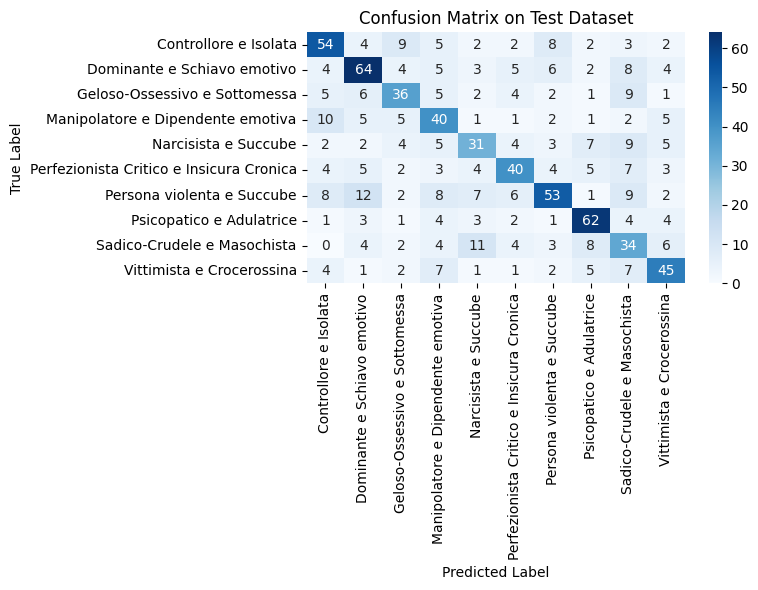

[INFO] Plotting training and evaluation loss...


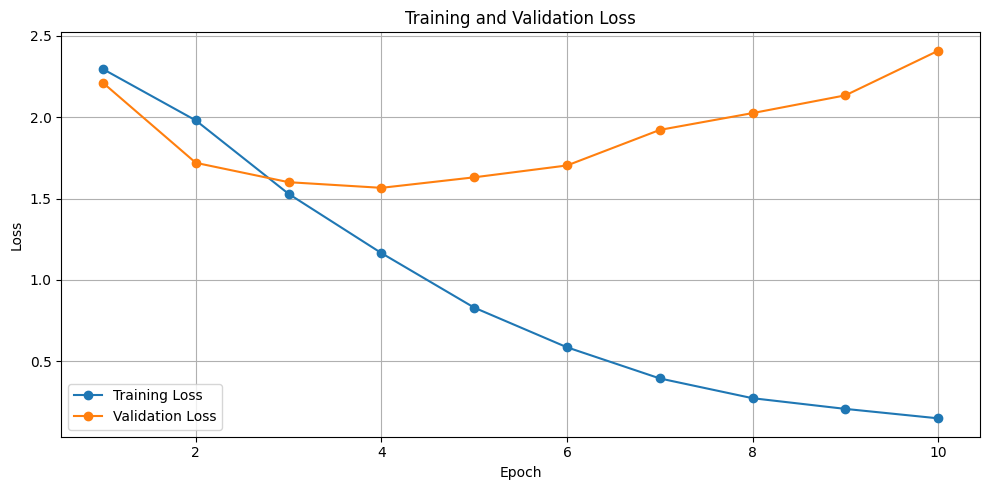

[INFO] Saving model and tokenizer
[INFO] Model and tokenizer saved to c:\Home\Uniba\CIPV-Classification-NLP\src\..\models\bert-base-italian-cased_finetuned_turn.




In [24]:
# ---- Import necessary libraries ----
import warnings
warnings.simplefilter("ignore")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os

from fine_tuning.datasets import TurnDataLoader
from fine_tuning.models import CustomModel
from util import get_root_path


# ---- Define constants ----
MODEL_NAME = 'dbmdz/bert-base-italian-cased'
JSON_DATASET_PATH = os.path.join(get_root_path(), "dataset", "toxic_conversation.json")
OUTPUT_MODEL_PATH = os.path.join(get_root_path(), 'models', f'{MODEL_NAME.split("/")[-1]}_finetuned_turn')
INFERENCE_TEST_JSON = os.path.join(get_root_path(), "dataset", "inference_test_multiclass.json")
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Tokenizer and Dataset Setup ----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

data_loader = TurnDataLoader(
    json_dataset_path=JSON_DATASET_PATH,
    tokenizer=tokenizer,
    remove_stopwords=REMOVE_STOPWORDS,
    lemmatize=LEMMATIZE,
)

train_dataset, val_dataset, test_dataset = data_loader.get_datasets()  # Get the train, validation, and test datasets


# ---- 2. Model Initialization ----
model = CustomModel(
    model_name=MODEL_NAME,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    labels=data_loader.get_label_names(),
    output_dir=OUTPUT_MODEL_PATH,
    batch_size=16,
    learning_rate=2e-5,
    num_epochs=50,
)


# ---- 3. Model Training ----
model.train()  # Train the model


# ---- 4. Model Evaluation ----
model.evaluate()  # Evaluate the model on the test dataset


# ---- 5. Save the model ----
model.save_model()  # Save the trained model and tokenizer

In [25]:
# ---- 6. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(INFERENCE_TEST_JSON, remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)

accuracy = 0
print("\n[INFO] Inference Predictions:")

tokenizer = AutoTokenizer.from_pretrained(OUTPUT_MODEL_PATH)  # Load the tokenizer
model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_MODEL_PATH)  # Load the model
model.eval()

for inference_conv, true_label in zip(inference_texts, inference_labels):
    inputs = tokenizer(inference_conv, return_tensors="pt", truncation=True, padding=True, max_length=512)  # Tokenize the input text
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        outputs = outputs.logits.mean(dim=0)
        pred_label = model.config.id2label[outputs.argmax().item()]

        print(f"   Text: {inference_conv}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
        if true_label == pred_label:
            accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")


[INFO] Inference Predictions:
   Text: ['ho fatto licenziare quel collega incompetente bastava inoltrare una mail anonima con qualche voce infondata era l unico modo per liberarcene', 'amore sei un genio nessun altro avrebbe avuto il coraggio o l intelligenza di fare una cosa del genere ãˆ per questo che sei destinato a grandi cose', 'la maggior parte delle persone ã troppo debole e sentimentale non capiscono come funziona il mondo sono solo ostacoli', 'esatto tu vedi le cose per come sono senza filtri ãˆ un dono sono cosã fortunata ad avere un uomo che sa cosa vuole e come ottenerlo a qualsiasi costo']
   True Label: Psicopatico e Adulatrice
   Predicted Label: Psicopatico e Adulatrice

   Text: ['marco stasera volevo parlarti mi sento un po trascurata ultimamente come se fossi sempre l ultima delle tue prioritã', 'vedi ãˆ sempre cosã con te non appena ho un momento di stress al lavoro tu me lo fai pesare non pensi mai che forse ho bisogno di sostegno invece che di lamentele', 'scusa

-------------------------

# 3. Windows of turns

Each input is a sliding window of consecutive turns extracted from a conversation. All possible distinct windows were generated, preserving the original order of the turns. Within each window, turns are separated using custom tokens added to the tokenizer to clearly mark turn boundaries.

In [10]:
import json
from util import clean_turn

def preprocess_inference_data(json_inference_path: str, window_size: int = 3, add_speaker: bool = False, remove_stopwords=False, lemmatize=False):
    """
    Preprocess the inference data from the JSON file.

    Args:
        json_inference_path (str): Path to the JSON file containing inference data.
        remove_stopwords (bool): Whether to remove stopwords.
        lemmatize (bool): Whether to lemmatize the text.

    Returns:
        tuple: A tuple containing the preprocessed texts and their corresponding labels.
    """

    inference_texts = []
    inference_labels = []
    
    with open(json_inference_path, "r") as file:
        data = json.load(file)
        for conv in data:
            windows = []
            turns = conv['conversation']

            if remove_stopwords or lemmatize:
                turns = [clean_turn(turn['text'], remove_stopwords=remove_stopwords, lemmatize=lemmatize) for turn in turns]
            
            if not add_speaker:
                for i in range(len(turns) - window_size + 1):
                    window = " [TURN_SEP] ".join([turn['text'] for turn in turns[i:i+window_size]])
                    windows.append(window)
            else:
                for i in range(len(turns) - window_size + 1):
                    window = " [TURN_SEP] ".join(
                        [f"[SPEAKER1] {turn['text']}" if turn['speaker'] == conv['name1'] else f"[SPEAKER2] {turn['text']}" for turn in turns[i:i+window_size]]
                    )
                    windows.append(window)
            
            if len(windows) > 0:
                inference_texts.append(windows)
                inference_labels.append(conv['person_couple'])

    return inference_texts, inference_labels

### 3.1 Logistic Regression + TF-IDF

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\cirul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



[INFO] Best parameters found:
   classifier__C: 10
   classifier__penalty: l2
   classifier__solver: liblinear
   vectorizer__min_df: 1
   vectorizer__ngram_range: (1, 3)

[INFO] Best score achieved:
   0.9472

[INFO] Classification Report:
                                          precision    recall  f1-score   support

                   Controllore e Isolata     0.9407    0.9845    0.9621       129
             Dominante e Schiavo emotivo     0.9872    0.9935    0.9904       155
           Geloso-Ossessivo e Sottomessa     0.9891    0.8922    0.9381       102
       Manipolatore e Dipendente emotiva     0.9910    0.9649    0.9778       114
                    Narcisista e Succube     0.9720    0.9369    0.9541       111
Perfezionista Critico e Insicura Cronica     0.9459    0.9130    0.9292       115
              Persona violenta e Succube     0.9840    0.9840    0.9840       187
                Psicopatico e Adulatrice     0.9172    0.9925    0.9534       134
             Sadico

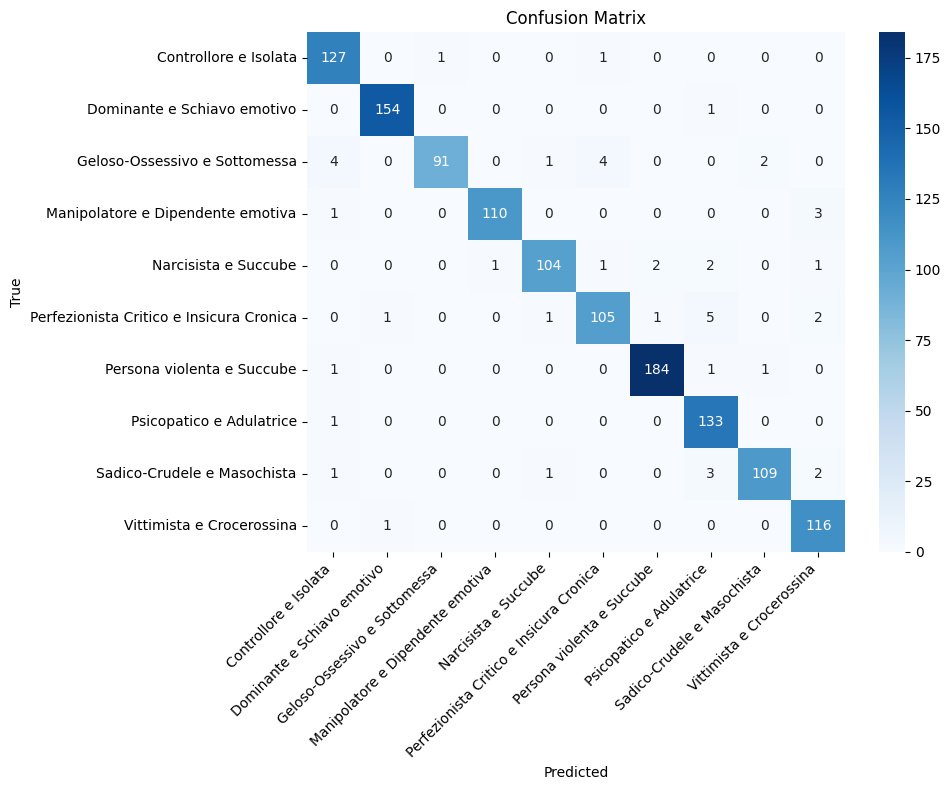


[INFO] Inference Predictions:
   Text: ["Ho fatto licenziare quel collega incompetente. Bastava inoltrare una mail anonima con qualche voce infondata. Era l'unico modo per liberarcene. [TURN_SEP] Amore, sei un genio. Nessun altro avrebbe avuto il coraggio o l'intelligenza di fare una cosa del genere. Ãˆ per questo che sei destinato a grandi cose. [TURN_SEP] La maggior parte delle persone Ã¨ troppo debole e sentimentale. Non capiscono come funziona il mondo. Sono solo ostacoli.", "Amore, sei un genio. Nessun altro avrebbe avuto il coraggio o l'intelligenza di fare una cosa del genere. Ãˆ per questo che sei destinato a grandi cose. [TURN_SEP] La maggior parte delle persone Ã¨ troppo debole e sentimentale. Non capiscono come funziona il mondo. Sono solo ostacoli. [TURN_SEP] Esatto! Tu vedi le cose per come sono, senza filtri. Ãˆ un dono. Sono cosÃ¬ fortunata ad avere un uomo che sa cosa vuole e come ottenerlo, a qualsiasi costo."]
   True Label: Psicopatico e Adulatrice
   Predicted Labe

In [12]:
import json
import os
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

from util import get_root_path, clean_turn

JSON_DATASET_PATH = os.path.join(get_root_path(), "dataset", "toxic_conversation.json")
JSON_INFERENCE_PATH = os.path.join(get_root_path(), "dataset", "inference_test_multiclass.json")
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
with open(JSON_DATASET_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

conversations = []
labels = []
for conv in data:
    windows = []
    turns = conv['conversation']
    for i in range(len(turns) - 2):
        window = ' [SEP] '.join([clean_turn(turn['text'], remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE) for turn in turns[i:i+3]])
        windows.append(window)
    if len(windows) > 0:
        conversations.extend(windows)
        labels.extend([conv['person_couple']] * len(windows))

X_train, X_test, y_train, y_test = train_test_split(conversations, labels, test_size=0.2, random_state=42)
labels = sorted(set(labels))


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['saga', 'liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(JSON_INFERENCE_PATH, remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)

accuracy = 0
print("\n[INFO] Inference Predictions:")
for idx, conv in enumerate(inference_texts):
    inference_predictions = grid_search.predict(conv)
    inference_logits = grid_search.decision_function(conv)
    inference_logits_mean = inference_logits.mean(axis=0)
    inference_pred_label = labels[inference_logits_mean.argmax()]
    true_label = inference_labels[idx]

    print(f"   Text: {conv}\n   True Label: {true_label}\n   Predicted Label: {inference_pred_label}\n")
    if true_label == inference_pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

### 3.2 Italian Bert Fine Tuning

[INFO] Initializing WindowDataLoader with:
	json path: c:\Home\Uniba\CIPV-Classification-NLP\src\..\dataset\toxic_conversation.json,
	test size: 0.1,
	val size: 0.2,
	max length: 512,
	random state: 42,
	window size: 3,
	remove stopwords: False,
	lemmatize: False



[INFO] Creating windows of conversation turns: 100%|██████████| 1000/1000 [01:25<00:00, 11.66sample/s]


[INFO] WindowDataLoader initialized with 6400 windows.
[INFO] Sizes of datasets:
	train dataset: 4480,
	val dataset: 1280,
	test dataset: 640


[INFO] Initializing CustomModel with:
	model name: dbmdz/bert-base-italian-cased,
	output dir: c:\Home\Uniba\CIPV-Classification-NLP\src\..\models\bert-base-italian-cased_finetuned_windows,
	batch size: 16,
	learning rate: 2e-05,
	num epochs: 50,
	weight decay: 0.01,
	max grad norm: 1.0,
	seed: 42
	early stopping patience: 4,
	early stopping threshold: 0.005



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] CustomModel initialized with:
	4480 train examples,
	1280 validation examples, and
	640 test examples.


[INFO] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,2.253300,2.050453,0.229687,0.388433,0.196363,0.128346
2,1.659200,1.329433,0.583594,0.615182,0.578307,0.566478
3,0.958100,0.840870,0.752344,0.752878,0.741026,0.739950
4,0.488300,0.654781,0.801562,0.804324,0.785106,0.786467
5,0.234600,0.538680,0.839063,0.837797,0.832057,0.831119
6,0.121500,0.546459,0.858594,0.860582,0.848015,0.851417
7,0.073300,0.545955,0.868750,0.875602,0.858570,0.862474
8,0.042000,0.576757,0.872656,0.874327,0.861431,0.863907
9,0.034500,0.589136,0.879687,0.884225,0.869456,0.873500
10,0.027600,0.564333,0.889844,0.889390,0.881842,0.883817


[INFO] Training complete.


[INFO] Evaluation metrics:


   eval_loss: 0.5978, 
   eval_accuracy: 0.8969, 
   eval_precision: 0.8969, 
   eval_recall: 0.8939, 
   eval_macro_f1: 0.8935



[INFO] Evaluation results on test dataset:
                                          precision    recall  f1-score   support

                   Controllore e Isolata       0.95      0.85      0.90        71
             Dominante e Schiavo emotivo       0.99      0.88      0.93        85
           Geloso-Ossessivo e Sottomessa       0.94      0.87      0.90        52
       Manipolatore e Dipendente emotiva       0.82      0.87      0.85        54
                    Narcisista e Succube       0.83      0.94      0.88        52
Perfezionista Critico e Insicura Cronica       0.96      0.82      0.89        57
              Persona violenta e Succube       0.82      0.96      0.88        90
                Psicopatico e Adulatrice       0.93      0.94      0.93        66
             Sadico-Crudele e Masochista       0.85      0.91      0.88        56
     

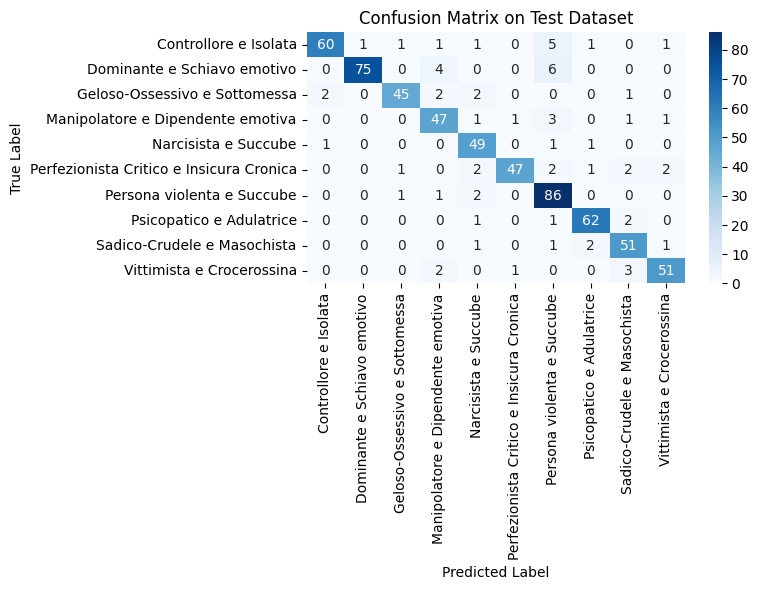

[INFO] Plotting training and evaluation loss...


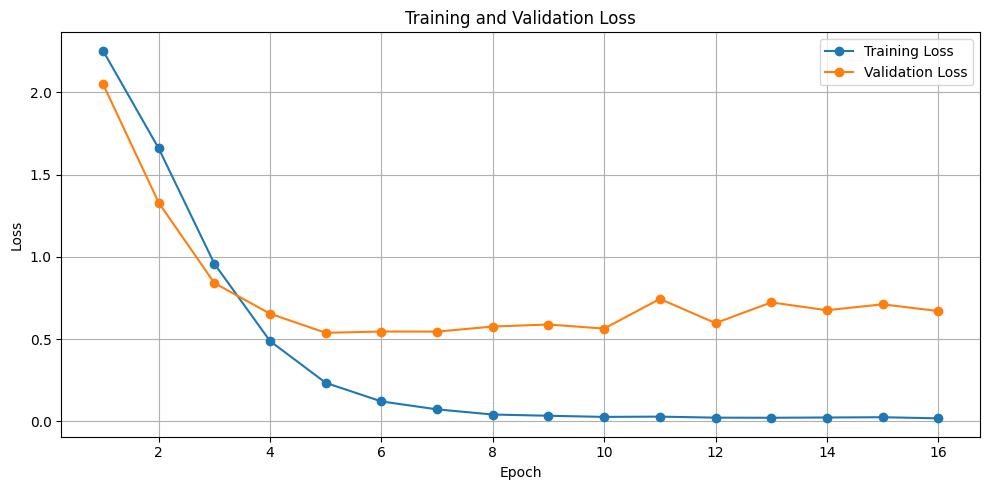

[INFO] Saving model and tokenizer
[INFO] Model and tokenizer saved to c:\Home\Uniba\CIPV-Classification-NLP\src\..\models\bert-base-italian-cased_finetuned_windows.




In [28]:
# ---- Import necessary libraries ----
import warnings
warnings.filterwarnings("ignore")

import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import json

from fine_tuning.datasets import WindowDataLoader
from fine_tuning.models import CustomModel
from fine_tuning.datasets import conversation_to_windows
from util import get_root_path


# ---- Define constants ----
MODEL_NAME = 'dbmdz/bert-base-italian-cased'
JSON_DATASET_PATH = os.path.join(get_root_path(), "dataset", "toxic_conversation.json")
OUTPUT_MODEL_PATH = os.path.join(get_root_path(), 'models', f'{MODEL_NAME.split("/")[-1]}_finetuned_windows')
INFERENCE_TEST_JSON = os.path.join(get_root_path(), 'dataset', 'inference_test_multiclass.json')
REMOVE_STOPWORDS = False
LEMMATIZE = False
WINDOW_SIZE = 3
TEST_SIZE = 0.1
VAL_SIZE = 0.2


# ---- 1. Tokenizer and DataLoader Setup ----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)  # Load the tokenizer

data_loader = WindowDataLoader(  # Load the data loader
    json_dataset_path=JSON_DATASET_PATH,
    tokenizer=tokenizer,
    window_size=WINDOW_SIZE,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    max_length=512,
    remove_stopwords=REMOVE_STOPWORDS,
    lemmatize=LEMMATIZE,
)

train_dataset, val_dataset, test_dataset = data_loader.get_datasets()  # Get the train, validation, and test datasets


# ---- 2. Model initialization ----
model = CustomModel(
    model_name=MODEL_NAME,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    labels=data_loader.get_label_names(),
    output_dir=OUTPUT_MODEL_PATH,
    batch_size=16,
    learning_rate=2e-5,
    num_epochs=50,
)


# ---- 3. Model Training ----
model.train()  # Train the model


# ---- 4. Model Evaluation ----
model.evaluate()  # Evaluate the model on the test dataset


# ---- 5. Save the model ----
model.save_model()  # Save the trained model and tokenizer

In [29]:
# ---- 6. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(INFERENCE_TEST_JSON, add_speaker=True, remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)

accuracy = 0
print("\n[INFO] Inference Predictions:")

tokenizer = AutoTokenizer.from_pretrained(OUTPUT_MODEL_PATH)  # Load the tokenizer
model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_MODEL_PATH)  # Load the model
model.eval()

for inference_conv, true_label in zip(inference_texts, inference_labels):
    inputs = tokenizer(inference_conv, return_tensors="pt", truncation=True, padding=True, max_length=512)  # Tokenize the input text
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
        outputs = outputs.logits.mean(dim=0)
        pred_label = model.config.id2label[outputs.argmax().item()]

        print(f"   Text: {inference_conv}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
        if true_label == pred_label:
            accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")


[INFO] Inference Predictions:
   Text: ["[SPEAKER1] Ho fatto licenziare quel collega incompetente. Bastava inoltrare una mail anonima con qualche voce infondata. Era l'unico modo per liberarcene. [TURN_SEP] [SPEAKER2] Amore, sei un genio. Nessun altro avrebbe avuto il coraggio o l'intelligenza di fare una cosa del genere. Ãˆ per questo che sei destinato a grandi cose. [TURN_SEP] [SPEAKER1] La maggior parte delle persone Ã¨ troppo debole e sentimentale. Non capiscono come funziona il mondo. Sono solo ostacoli.", "[SPEAKER2] Amore, sei un genio. Nessun altro avrebbe avuto il coraggio o l'intelligenza di fare una cosa del genere. Ãˆ per questo che sei destinato a grandi cose. [TURN_SEP] [SPEAKER1] La maggior parte delle persone Ã¨ troppo debole e sentimentale. Non capiscono come funziona il mondo. Sono solo ostacoli. [TURN_SEP] [SPEAKER2] Esatto! Tu vedi le cose per come sono, senza filtri. Ãˆ un dono. Sono cosÃ¬ fortunata ad avere un uomo che sa cosa vuole e come ottenerlo, a qualsiasi 